In [54]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
from controllers import DeePC
import gym
import mujoco_py
from gym import wrappers
from IPython import display

plt.rcParams["figure.figsize"] = (15,5)

%matplotlib inline
%reload_ext autoreload
%autoreload 

## Data Collection

In [55]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')

"""
    Timestep for InvertedPendelum-v4 is 0.02
"""

obs, info = env.reset()

Tini = 1
n = 4
N = 20
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 10
print(T)
render_collection = False

ud = []
yd = []
i = 0

while i < T:

    # restart loop if data is non-linear
    if np.abs(obs[1]) > 0.1 or np.abs(obs[0]) > 0.05 or np.abs(obs[2]) > 0.05 or np.abs(obs[3]) > 0.15 :
        obs, info = env.reset()
        i = 0
        ud = []
        yd = []

    # Add noise to action and roll sim forward
    action = [obs[1]*2 - np.random.randn()*0.01]
    obs, rew, done, info, _ = env.step(action)
    # obs += np.random.randn(p,)*0.01
    ud = np.append(ud,action)
    yd = np.append(yd,obs)

    # display gym annimation if requested
    if render_collection:
        plt.title(f"Action {action[0]:.2f} Theta {obs[1]:.2f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    i+=1

env.close()
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

60
yd shape : (240,)   ud shape : (60,)


## Controller Setup

In [56]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_const = np.kron(np.ones(N), np.array([0.05, 0.05, 0.05, 0.05]))
u_const = np.ones(N)*3
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_const, u_constraints=u_const,
    N=N, Tini=Tini, n=n, T=T, p=p, m=m, Q=Q, R=R
)

## Simulation

ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

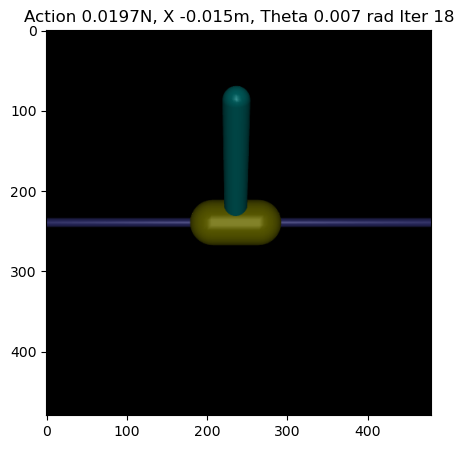

In [57]:
yT = [*y_ini]
uT = [*u_ini]
ref = np.zeros(N*p)

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
render = True
iter = 0

while iter < 100:

    # Solve for optimal input
    controller.setup(ref=ref, u_ini=u_ini, y_ini=y_ini, lam_g1=1000, lam_g2=100000)
    action = controller.solve(solver=cp.OSQP, verbose=False)

    # roll simulation forward
    obs,_,done,_,_ = env.step(action)
    # obs += np.random.randn(p,)*0.01
    yT = np.append(yT, obs)
    uT = np.append(uT, action)
    
    # break from sim if constraints are violated
    if np.abs(obs[1]) > 0.2 or np.abs(obs[0]) > 0.2 or np.abs(obs[2]) > 0.2 or np.abs(obs[3]) > 0.2 : break

    # Render gym env
    if render:
        plt.title(f"Action {action[0]:.4f}N, X {obs[0]:.3f}m, Theta {obs[1]:.3f} rad Iter {iter}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    # Reset initial conditions
    u_ini = uT[-Tini:]
    y_ini = yT[-p*Tini:]
    iter += 1

## Visualisation

In [ ]:
uT = uT[Tini*m:]
yT = yT[Tini*p:]
T = len(uT)
yT = yT.reshape((T,p))
uT = uT.reshape((T,m))

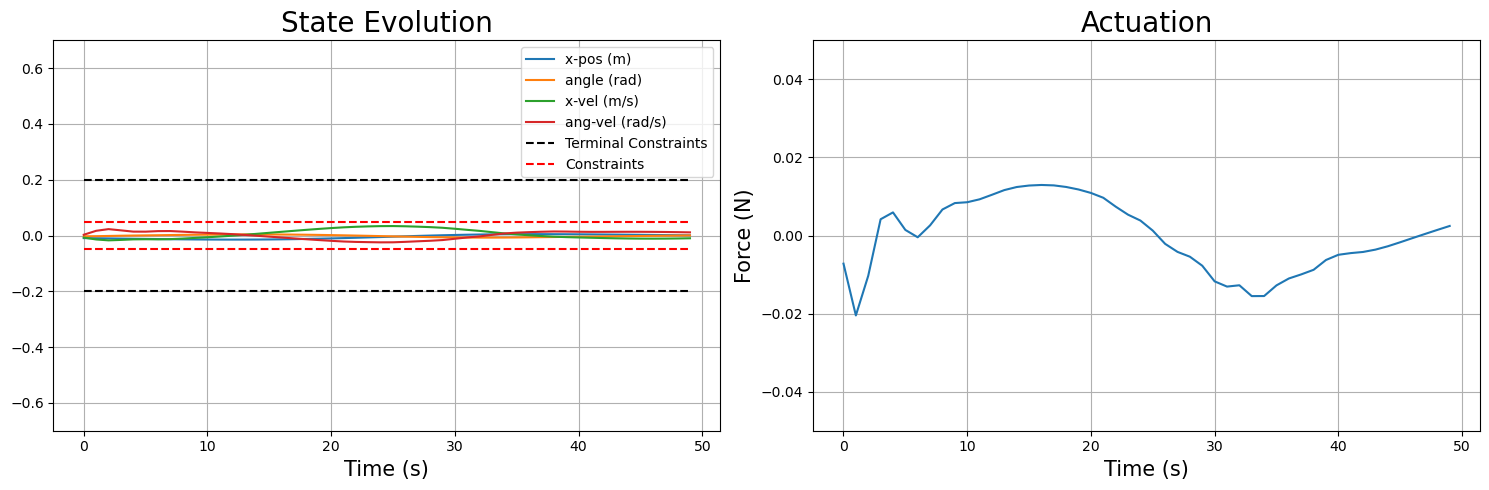

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos (m)', 'angle (rad)', 'x-vel (m/s)', 'ang-vel (rad/s)'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='Terminal Constraints')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.plot(range(0,T), np.ones(T)*0.05, 'r--',label='Constraints')
plt.plot(range(0,T), -np.ones(T)*0.05, 'r--')
plt.legend(loc="upper right")
plt.ylim((-0.7,0.7))
plt.xlabel('Time (s)', fontdict={'fontsize':15})
plt.title("State Evolution", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.ylabel('Force (N)', fontdict={'fontsize':15})
plt.xlabel('Time (s)', fontdict={'fontsize':15})
plt.title("Actuation", fontdict={'fontsize':20})
plt.ylim((-0.05,0.05))
plt.grid('on')
plt.tight_layout()

plt.show()